In [1]:
#| default_exp datasets

In [2]:
%load_ext lab_black

In [3]:
# |export
from __future__ import annotations
import math, numpy as np, matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch.utils.data import default_collate
from nbdev.showdoc import show_doc

# from miniai.training import *

In [44]:
import logging, pickle, gzip, os, time, shutil, torch, matplotlib as mpl
from pathlib import Path

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [5]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams["image.cmap"] = "gray"

In [6]:
logging.disable(logging.WARNING)

## Hugging Face Datasets

In [7]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [8]:
[attr for attr in dir(ds_builder) if not attr.startswith("_")]

['BUILDER_CONFIGS',
 'BUILDER_CONFIG_CLASS',
 'DEFAULT_CONFIG_NAME',
 'DEFAULT_WRITER_BATCH_SIZE',
 'VERSION',
 'as_dataset',
 'as_streaming_dataset',
 'base_path',
 'builder_configs',
 'cache_dir',
 'config',
 'config_id',
 'dl_manager',
 'download_and_prepare',
 'download_post_processing_resources',
 'get_all_exported_dataset_infos',
 'get_exported_dataset_info',
 'get_imported_module_dir',
 'hash',
 'info',
 'manual_download_instructions',
 'name',
 'repo_id',
 'storage_options',
 'use_auth_token']

In [9]:
[attr for attr in dir(ds_builder.info) if not attr.startswith("_")]

['builder_name',
 'citation',
 'config_name',
 'copy',
 'dataset_size',
 'description',
 'download_checksums',
 'download_size',
 'features',
 'from_dict',
 'from_directory',
 'from_merge',
 'homepage',
 'license',
 'post_processed',
 'post_processing_size',
 'size_in_bytes',
 'splits',
 'supervised_keys',
 'task_templates',
 'update',
 'version',
 'write_to_directory']

In [10]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [11]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [12]:
dsd = load_dataset(name)
dsd

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 69.46it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [13]:
train, test = dsd["train"], dsd["test"]
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [14]:
x, y = ds_builder.info.features

In [15]:
x, y

('image', 'label')

In [16]:
x, y = train.info.features
img = train[0][x]
img

In [17]:
train[:5]

{'image': [<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
  <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>],
 'label': [9, 0, 0, 3, 0]}

In [18]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [19]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [20]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [21]:
train["label"][:5]

[9, 0, 0, 3, 0]

In [22]:
def collate_fn(batch):
    return {
        x: torch.stack([TF.to_tensor(o[x]) for o in batch]),
        y: tensor([o[y] for o in batch]),
    }

In [23]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

pytorch's `DataLoader` can take a dataset of type `dictionary` or any object as long as it implements `__getitem__` and `__len__` special methods. Therefore, HuggingFace datasets works perfectly with `DataLoaders` as long as we define a `collate` function to stack and convert data to tensors.

In [24]:
# HF datasets allow us to define transforms that does the same things
# as collate function and more. This will be applied to every item in the
# bacth when we index into the dataset (on the fly)
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    # We need the return here because HF expects the transforms
    # to return the new version of the transformed data
    return b

In [25]:
tds = train.with_transform(transforms)
# Pytorch already knows how to stack dictionaries of tensors
# So we dont need to use collate function, but it will return
# dictionary
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
type(b), b[x].shape, b[y]

(dict,
 torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [26]:
def _transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [27]:
# |export
def inplace(f):
    def _f(b):
        f(b)
        return b

    return _f

In [28]:
transformi = inplace(_transformi)

In [29]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [30]:
@inplace
def transformi(b):
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [31]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [32]:
itemgetter?

Init signature: itemgetter(self, /, *args, **kwargs)
Docstring:     
itemgetter(item, ...) --> itemgetter object

Return a callable object that fetches the given item(s) from its operand.
After f = itemgetter(2), the call f(r) returns r[2].
After g = itemgetter(2, 5, 3), the call g(r) returns (r[2], r[5], r[3])
File:           ~/mambaforge/envs/dl/lib/python3.11/operator.py
Type:           type
Subclasses:     

In [33]:
d = dict(a=1, b=2, c=3)
ig = itemgetter("a", "c")
ig(d)

(1, 3)

In [34]:
class D:
    def __getitem__(self, k):
        return 1 if k == "a" else 2 if k == "b" else 3

In [35]:
d = D()
ig(d)

(1, 3)

In [36]:
list(tdsf.features)

['image', 'label']

In [37]:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [40]:
type(dsd)

datasets.dataset_dict.DatasetDict

In [41]:
# |export
def collate_dict(ds):
    get = itemgetter(*ds.features)

    def _f(batch):
        # default_collate(batch) -> dictionary where values are stacked tensors
        # get() would return the tuple of stacked tensors instead of dictionary
        return get(default_collate(batch))

    return _f

In [42]:
default_collate?

Signature: default_collate(batch)
Docstring:
Function that takes in a batch of data and puts the elements within the batch
into a tensor with an additional outer dimension - batch size. The exact output type can be
a :class:`torch.Tensor`, a `Sequence` of :class:`torch.Tensor`, a
Collection of :class:`torch.Tensor`, or left unchanged, depending on the input type.
This is used as the default function for collation when
`batch_size` or `batch_sampler` is defined in :class:`~torch.utils.data.DataLoader`.

Here is the general input type (based on the type of the element within the batch) to output type mapping:

    * :class:`torch.Tensor` -> :class:`torch.Tensor` (with an added outer dimension batch size)
    * NumPy Arrays -> :class:`torch.Tensor`
    * `float` -> :class:`torch.Tensor`
    * `int` -> :class:`torch.Tensor`
    * `str` -> `str` (unchanged)
    * `bytes` -> `bytes` (unchanged)
    * `Mapping[K, V_i]` -> `Mapping[K, default_collate([V_1, V_2, ...])]`
    * `NamedTuple[V1_i, 

In [45]:
class DS(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return self.data[idx], self.data[idx]
        return 0, 1

In [46]:
a = np.arange(100)
ds_a = DS(a)
ds_a[0]

(0, 1)

In [47]:
next(iter(DataLoader(ds_a, 5)))

[tensor([0, 0, 0, 0, 0]), tensor([1, 1, 1, 1, 1])]

In [48]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb.shape

(torch.Size([4, 784]), torch.Size([4]))

## Plotting images

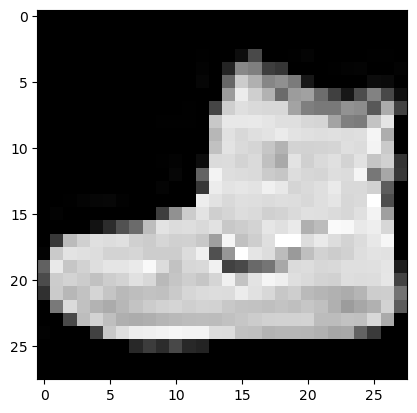

In [49]:
b = next(iter(dl))
xb = b["image"]
img = xb[0]
plt.imshow(img[0])

In [50]:
# |export
# delegates take an argument and add the `kwargs` using the argument we used
# In our case here, it uses all the arguments from plt.Axes.imshow
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ("cpu", "permute", "detach")):
        im = im.detach().cpu()
        if len(im.shape) == 3 and im.shape[0] < 5:
            im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray):
        im = np.array(im)
    if im.shape[-1] == 1:
        im = im[..., 0]
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe:
        ax.axis("off")
    return ax

In [119]:
show_image?

Signature:
show_image(
    im,
    ax=None,
    figsize=None,
    title=None,
    noframe=True,
    *,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    interpolation_stage=None,
    filternorm=True,
    filterrad=4.0,
    resample=None,
    url=None,
    data=None,
)
Docstring: Show a PIL or PyTorch image on `ax`.
File:      /var/folders/_k/c1pmn5411mq47r918y2y15pr0000gn/T/ipykernel_72515/2241758370.py
Type:      function

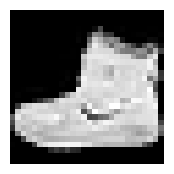

In [120]:
show_image(img, figsize=(2, 2))

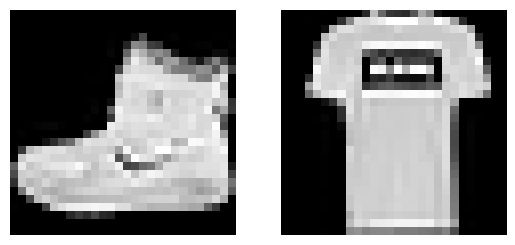

In [121]:
fig, axs = plt.subplots(1, 2)
show_image(img, axs[0])
show_image(xb[1], axs[1])

In [125]:
# |export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int = 1,  # Number of rows in returned axes grid
    ncols: int = 1,  # Number of columns in returned axes grid
    figsize: tuple = None,  # Width, height in inches of the returned figure
    imsize: int = 3,  # Size (in inches) of images that will be displayed in the returned figure
    suptitle: str = None,  # Title to be set to returned figure
    **kwargs
):  # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None:
        figsize = (ncols * imsize, nrows * imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None:
        fig.suptitle(suptitle)
    if nrows * ncols == 1:
        ax = np.array([ax])
    return fig, ax

In [126]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                width_ratios=None, height_ratios=None, subplot_kw=None,
>                gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| width_ratios | NoneType | None |  |
| height_ratios | NoneType | None |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

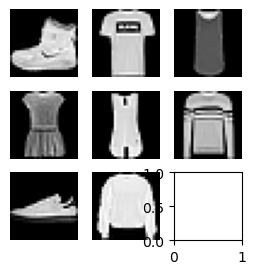

In [127]:
fig, axs = subplots(3, 3, imsize=1)
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs):
    show_image(img, ax)

In [128]:
# |export
@fc.delegates(subplots)
def get_grid(
    n: int,  # Number of axes
    nrows: int = None,  # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols: int = None,  # Number of columns, defaulting to `ceil(n/rows)`
    title: str = None,  # If passed, title set to the figure
    weight: str = "bold",  # Title font weight
    size: int = 14,  # Title font size
    **kwargs,
):  # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows:
        ncols = ncols or int(np.floor(n / nrows))
    elif ncols:
        nrows = nrows or int(np.ceil(n / ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n / nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows * ncols):
        axs.flat[i].set_axis_off()
    if title is not None:
        fig.suptitle(title, weight=weight, size=size)
    return fig, axs

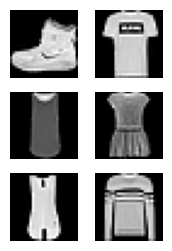

In [129]:
fig, axs = get_grid(8, nrows=3, imsize=1)
for ax, img in zip(axs.flat, imgs):
    show_image(img, ax)

In [130]:
# |export
@fc.delegates(subplots)
def show_images(
    ims: list,  # Images to show
    nrows: int | None = None,  # Number of rows in grid
    ncols: int | None = None,  # Number of columns in grid (auto-calculated if None)
    titles: list | None = None,  # Optional list of titles for each image
    **kwargs
):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs):
        show_image(im, ax=ax, title=t)

In [137]:
yb = b["label"]
lbls = yb[:8]

In [138]:
# names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
names = train.features["label"].names
titles = itemgetter(*lbls)(names)
" ".join(titles)

'Ankle boot T - shirt / top T - shirt / top Dress T - shirt / top Pullover Sneaker Pullover'

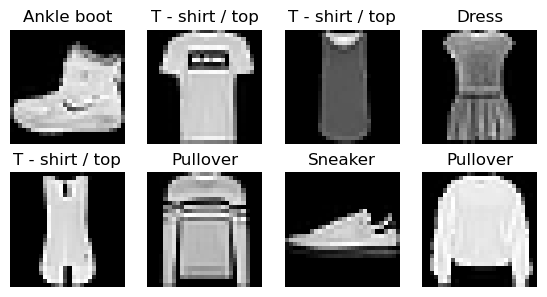

In [139]:
show_images(imgs, imsize=1.7, titles=titles)

In [143]:
# |export
class DataLoaders:
    def __init__(self, *dls):
        self.train, self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        # dd: data dictionary that includes different splits such as
        # the HF data dictionary
        f = collate_dict(dd["train"])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()